## Similarity-based querying of synapses using SynapseCLR representations

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from cuml import PCA, TSNE, UMAP

from synapse_utils import io

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
repo_root = '../..'
run_id = 'synapseclr__so3__seed_42__second_stage'
checkpoint_path = f'../../output/checkpoint__{run_id}'
dataset_path = '../../data/MICrONS__L23__8_8_40__processed'

reload_epoch = 99
node_idx_list = [0, 1, 2, 3]
contamination_indices_path = '../../tables/meta_df_contamination_indices.npy'

In [3]:
# load features
load_prefix = 'encoder.fc'
save_prefix = load_prefix.replace('.', '_')
l2_normalize = False

features_nf, meta_df, meta_ext_df = io.load_features(
    checkpoint_path,
    node_idx_list,
    reload_epoch,
    feature_hook=load_prefix,
    dataset_path=dataset_path,
    l2_normalize=l2_normalize,
    contamination_indices_path=contamination_indices_path)

## 2D Embedding

In [4]:
# load features
load_prefix = 'encoder.fc'
save_prefix = load_prefix.replace('.', '_')
l2_normalize = False

features_nf, meta_df, meta_ext_df = io.load_features(
    checkpoint_path,
    node_idx_list,
    reload_epoch,
    feature_hook=load_prefix,
    dataset_path=dataset_path,
    l2_normalize=l2_normalize,
    contamination_indices_path=contamination_indices_path)

n_pca_components = 128
if n_pca_components < features_nf.shape[-1]:
    features_nf = PCA(n_components=n_pca_components).fit_transform(features_nf)

In [5]:
# (optionally) load
import pickle

embedding_2d_loaded = False

try:
    
    embedding_type = 'UMAP'
    features_n2 = np.load(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d.npy'))

    with open(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d__fit.pkl'), 'rb') as f:
        loader = pickle.Unpickler(f)
        umap_2d_fit = loader.load()

    embedding_2d_loaded = True
    
except:
    pass

In [6]:
if not embedding_2d_loaded:
    
    embedding_type = 'UMAP'
    save_results = True

    # for UMAP
    n_neighbors = 500
    n_epochs = 5000
    learning_rate = 1.0
    spread = 1.0
    min_dist = 0.1

    # for t-SNE
    perplexity = 10

    if embedding_type == 'UMAP':

        umap_2d_fit = UMAP(
            min_dist=min_dist,
            spread=spread,
            n_neighbors=n_neighbors,
            learning_rate=learning_rate,
            n_epochs=n_epochs,
            random_state=42).fit(features_nf)

        features_n2 = umap_2d_fit.embedding_

        # save embedding
        import pickle

        if save_results:

            os.makedirs(os.path.join(checkpoint_path, 'embeddings'), exist_ok=True)
            with open(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d__fit.pkl'), 'wb') as f:
                pickle.dump(umap_2d_fit, f)
            np.save(
                os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d.npy'),
                features_n2)

    elif embedding_type == 'TSNE':

        tsne_2d_fit = TSNE(
            perplexity=perplexity,
            n_neighbors=n_neighbors,
            learning_rate_method=None).fit(features_nf)

        features_n2 = tsne_2d_fit.embedding_

        # save embedding
        import pickle

        if save_results:

            os.makedirs(os.path.join(checkpoint_path, 'embeddings'), exist_ok=True)
            with open(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__tsne_2d__fit.pkl'), 'wb') as f:
                pickle.dump(tsne_2d_fit, f)
            np.save(
                os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__tsne_2d.npy'),
                features_n2)

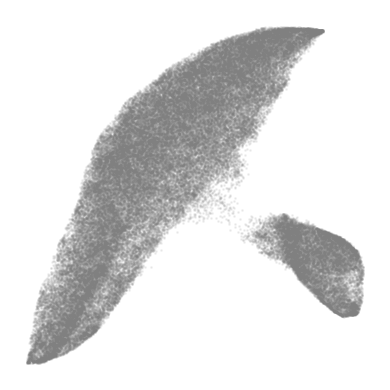

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=1.,
    vmin=-2, vmax=2,
    alpha=0.1,
    color='gray',
    rasterized=True)

ax.set_xlabel(f'{embedding_type} 1', fontsize=14)
ax.set_ylabel(f'{embedding_type} 2', fontsize=14)
ax.axis('off')
fig.tight_layout()

## Query synapse IDs

In [8]:
synapse_ids = [
    1317707,
    2341444,
    854689,
    155308,
    828459,
    1726363,
    2825002,
    1615486,
    1924577
]

top_k = 7
max_dist = 12
bins = 100

## Generate 3D renders of nearest neighbor synapses

In [9]:
from synapse_utils import vis

ctx = vis.SynapseVisContext(
    dataset_path,
    f'../../configs/config__ext/augmenter_display.yaml',
    meta_df_override=meta_df,
    device='cuda')

In [10]:
elements_output_path = os.path.join(checkpoint_path, 'analysis', 'knn_demo', 'elements')
os.makedirs(elements_output_path, exist_ok=True)

for synapse_id in synapse_ids:

    synapse_index = {
        _synapse_id: _idx for _idx, _synapse_id in enumerate(meta_df['synapse_id'].values)}[synapse_id]

    dist_n = np.linalg.norm(features_nf - features_nf[synapse_index][None], axis=1)
    sorted_dist_n = sorted(dist_n)[1:]    
    distances_k = [0] + sorted_dist_n[:top_k]
    vis_indices_k = np.argsort(dist_n)[:(top_k + 1)]

    for i, vis_synapse_index in enumerate(vis_indices_k):
        vis_synapse_id = meta_df.iloc[vis_synapse_index].synapse_id
        print(f'{synapse_id}, {vis_synapse_id} ...')
        
        output_filename = os.path.join(
            elements_output_path, f'query__{synapse_id}__{i}__{vis_synapse_id}.png')
        if os.path.exists(output_filename):
            continue
        fig = vis.make_3d_synapse_figure(
            ctx,
            vis_synapse_index,
            view_plane=2,
            surface_point_cloud_opacity=0.06);
        fig.write_image(output_filename)

1317707, 1317707 ...
1317707, 3512143 ...
1317707, 643158 ...
1317707, 184120 ...
1317707, 3263034 ...
1317707, 1100076 ...
1317707, 900155 ...
1317707, 3350208 ...
2341444, 2341444 ...
2341444, 1566653 ...
2341444, 2137707 ...
2341444, 3383144 ...
2341444, 938471 ...
2341444, 3223401 ...
2341444, 2468059 ...
2341444, 3478209 ...
854689, 854689 ...
854689, 2800443 ...
854689, 2780733 ...
854689, 2743348 ...
854689, 2278427 ...
854689, 2897196 ...
854689, 3447213 ...
854689, 2779217 ...
155308, 155308 ...
155308, 3553835 ...
155308, 483621 ...
155308, 87124 ...
155308, 94703 ...
155308, 426161 ...
155308, 256915 ...
155308, 152666 ...
828459, 828459 ...
828459, 424170 ...
828459, 34257 ...
828459, 2853959 ...
828459, 3386367 ...
828459, 1227129 ...
828459, 3049041 ...
828459, 3125592 ...
1726363, 1726363 ...
1726363, 3068846 ...
1726363, 1887997 ...
1726363, 1445824 ...
1726363, 1948417 ...
1726363, 669305 ...
1726363, 1680679 ...
1726363, 1953027 ...
2825002, 2825002 ...
2825002, 26894

## Make UMAP highlighting nearest neighbors

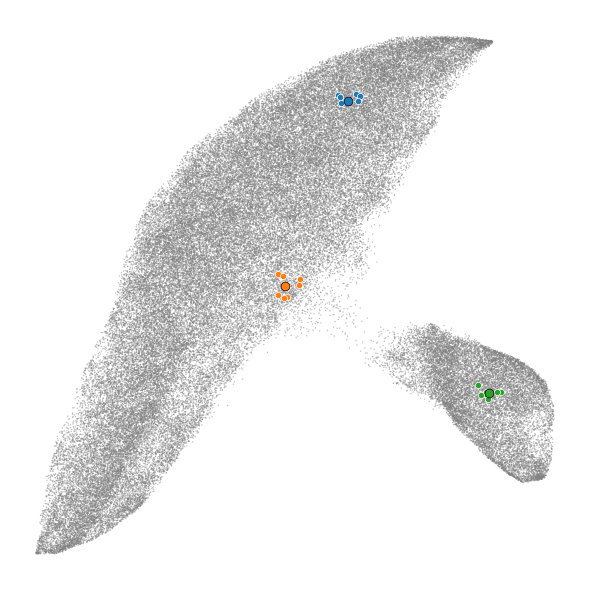

In [11]:
import colorcet as cc

fig, ax = plt.subplots(figsize=(6, 6))

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=1.,
    vmin=-2, vmax=2,
    alpha=0.5,
    color='gray',
    edgecolor='none',
    rasterized=True)

synapse_ids = [
    1317707,
    1924577,
    2341444
]

for i, synapse_id in enumerate(synapse_ids):
    
    synapse_index = {
        _synapse_id: _idx for _idx, _synapse_id in enumerate(meta_df['synapse_id'].values)}[synapse_id]

    dist_n = np.linalg.norm(features_nf - features_nf[synapse_index][None], axis=1)
    distances_k = [0] + sorted_dist_n[:top_k]
    vis_indices_k = np.argsort(dist_n)[:(top_k + 1)]
    
    sc = ax.scatter(
        features_n2[vis_indices_k, 0],
        features_n2[vis_indices_k, 1],
        s=20,
        edgecolor='white',
        lw=0.5,
        color=cc.glasbey_category10[i])

    sc = ax.scatter(
        [features_n2[synapse_index, 0]],
        [features_n2[synapse_index, 1]],
        s=40,
        edgecolor='black',
        lw=0.5,
        color=cc.glasbey_category10[i])

ax.set_xlabel(f'{embedding_type} 1', fontsize=14)
ax.set_ylabel(f'{embedding_type} 2', fontsize=14)
ax.set_box_aspect(1.)
ax.axis('off')
fig.tight_layout()

umap_output_path = os.path.join(checkpoint_path, 'analysis', 'knn_demo', 'umap')
os.makedirs(umap_output_path, exist_ok=True)
fig.savefig(os.path.join(umap_output_path, f'umap__{save_prefix}__with_knn.pdf'), dpi=200, bbox_inches='tight')

## Make UMAP highlighting similarity scores

Note: this relies on having UMAP embeddings created;  please return back to this cell.

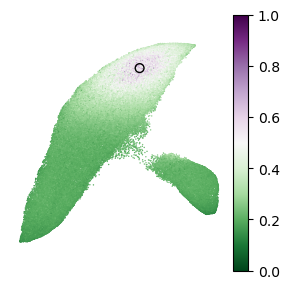

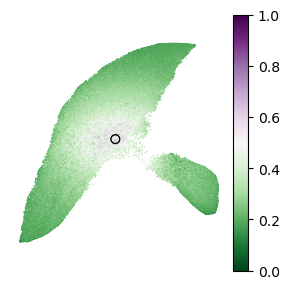

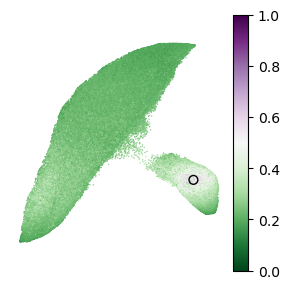

In [12]:
umap_output_path = os.path.join(checkpoint_path, 'analysis', 'knn_demo', 'umap')
os.makedirs(umap_output_path, exist_ok=True)

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

for i, synapse_id in enumerate(synapse_ids):

    synapse_index = {
        _synapse_id: _idx for _idx, _synapse_id in enumerate(meta_df['synapse_id'].values)}[synapse_id]

    dist_n = np.linalg.norm(features_nf - features_nf[synapse_index][None], axis=1)
    score_n = np.exp(-0.2 * dist_n)
    
    fig, ax = plt.subplots(figsize=(3, 3))

    sc = ax.scatter(
        features_n2[:, 0],
        features_n2[:, 1],
        c=score_n,
        cmap=plt.cm.PRGn_r,
        edgecolor='none',
        s=1,
        vmin=0,
        vmax=1,
        alpha=1.,
        rasterized=True)

    ax1_divider = make_axes_locatable(ax)
    # Add an Axes to the right of the main Axes.
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    cb1 = fig.colorbar(sc, cax=cax1)
    cb1.ax.tick_params(labelsize=10)
    
    sc = ax.scatter(
        features_n2[synapse_index, 0],
        features_n2[synapse_index, 1],
        lw=1.,
        s=40,
        facecolor='none',
        edgecolor='black')

    ax.set_xlabel(f'{embedding_type} 1', fontsize=14)
    ax.set_ylabel(f'{embedding_type} 2', fontsize=14)
    ax.set_box_aspect(1.)
    ax.set_axis_off()
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()
    
    fig.savefig(
        os.path.join(umap_output_path, f'synapse_simclr_knn_demo_umap__{i}__{synapse_id}.pdf'),
        dpi=200, bbox_inches='tight')

## Make a tile plot

In [13]:
import matplotlib.image as img
from matplotlib.gridspec import GridSpec

In [14]:
suffix = 'large'
synapse_ids = [
    1317707,
    2341444,
    854689,
    155308,
    828459,
    1726363,
    2825002,
    1615486,
    1924577
]

# suffix = 'small'
# synapse_ids = [
#     1317707,
#     1924577,
#     2341444,
# ]

In [15]:
SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [16]:
elements_output_path = os.path.join(checkpoint_path, 'analysis', 'knn_demo', 'elements')
umap_output_path = os.path.join(checkpoint_path, 'analysis', 'knn_demo', 'umap')
tile_output_path = os.path.join(checkpoint_path, 'analysis', 'knn_demo')

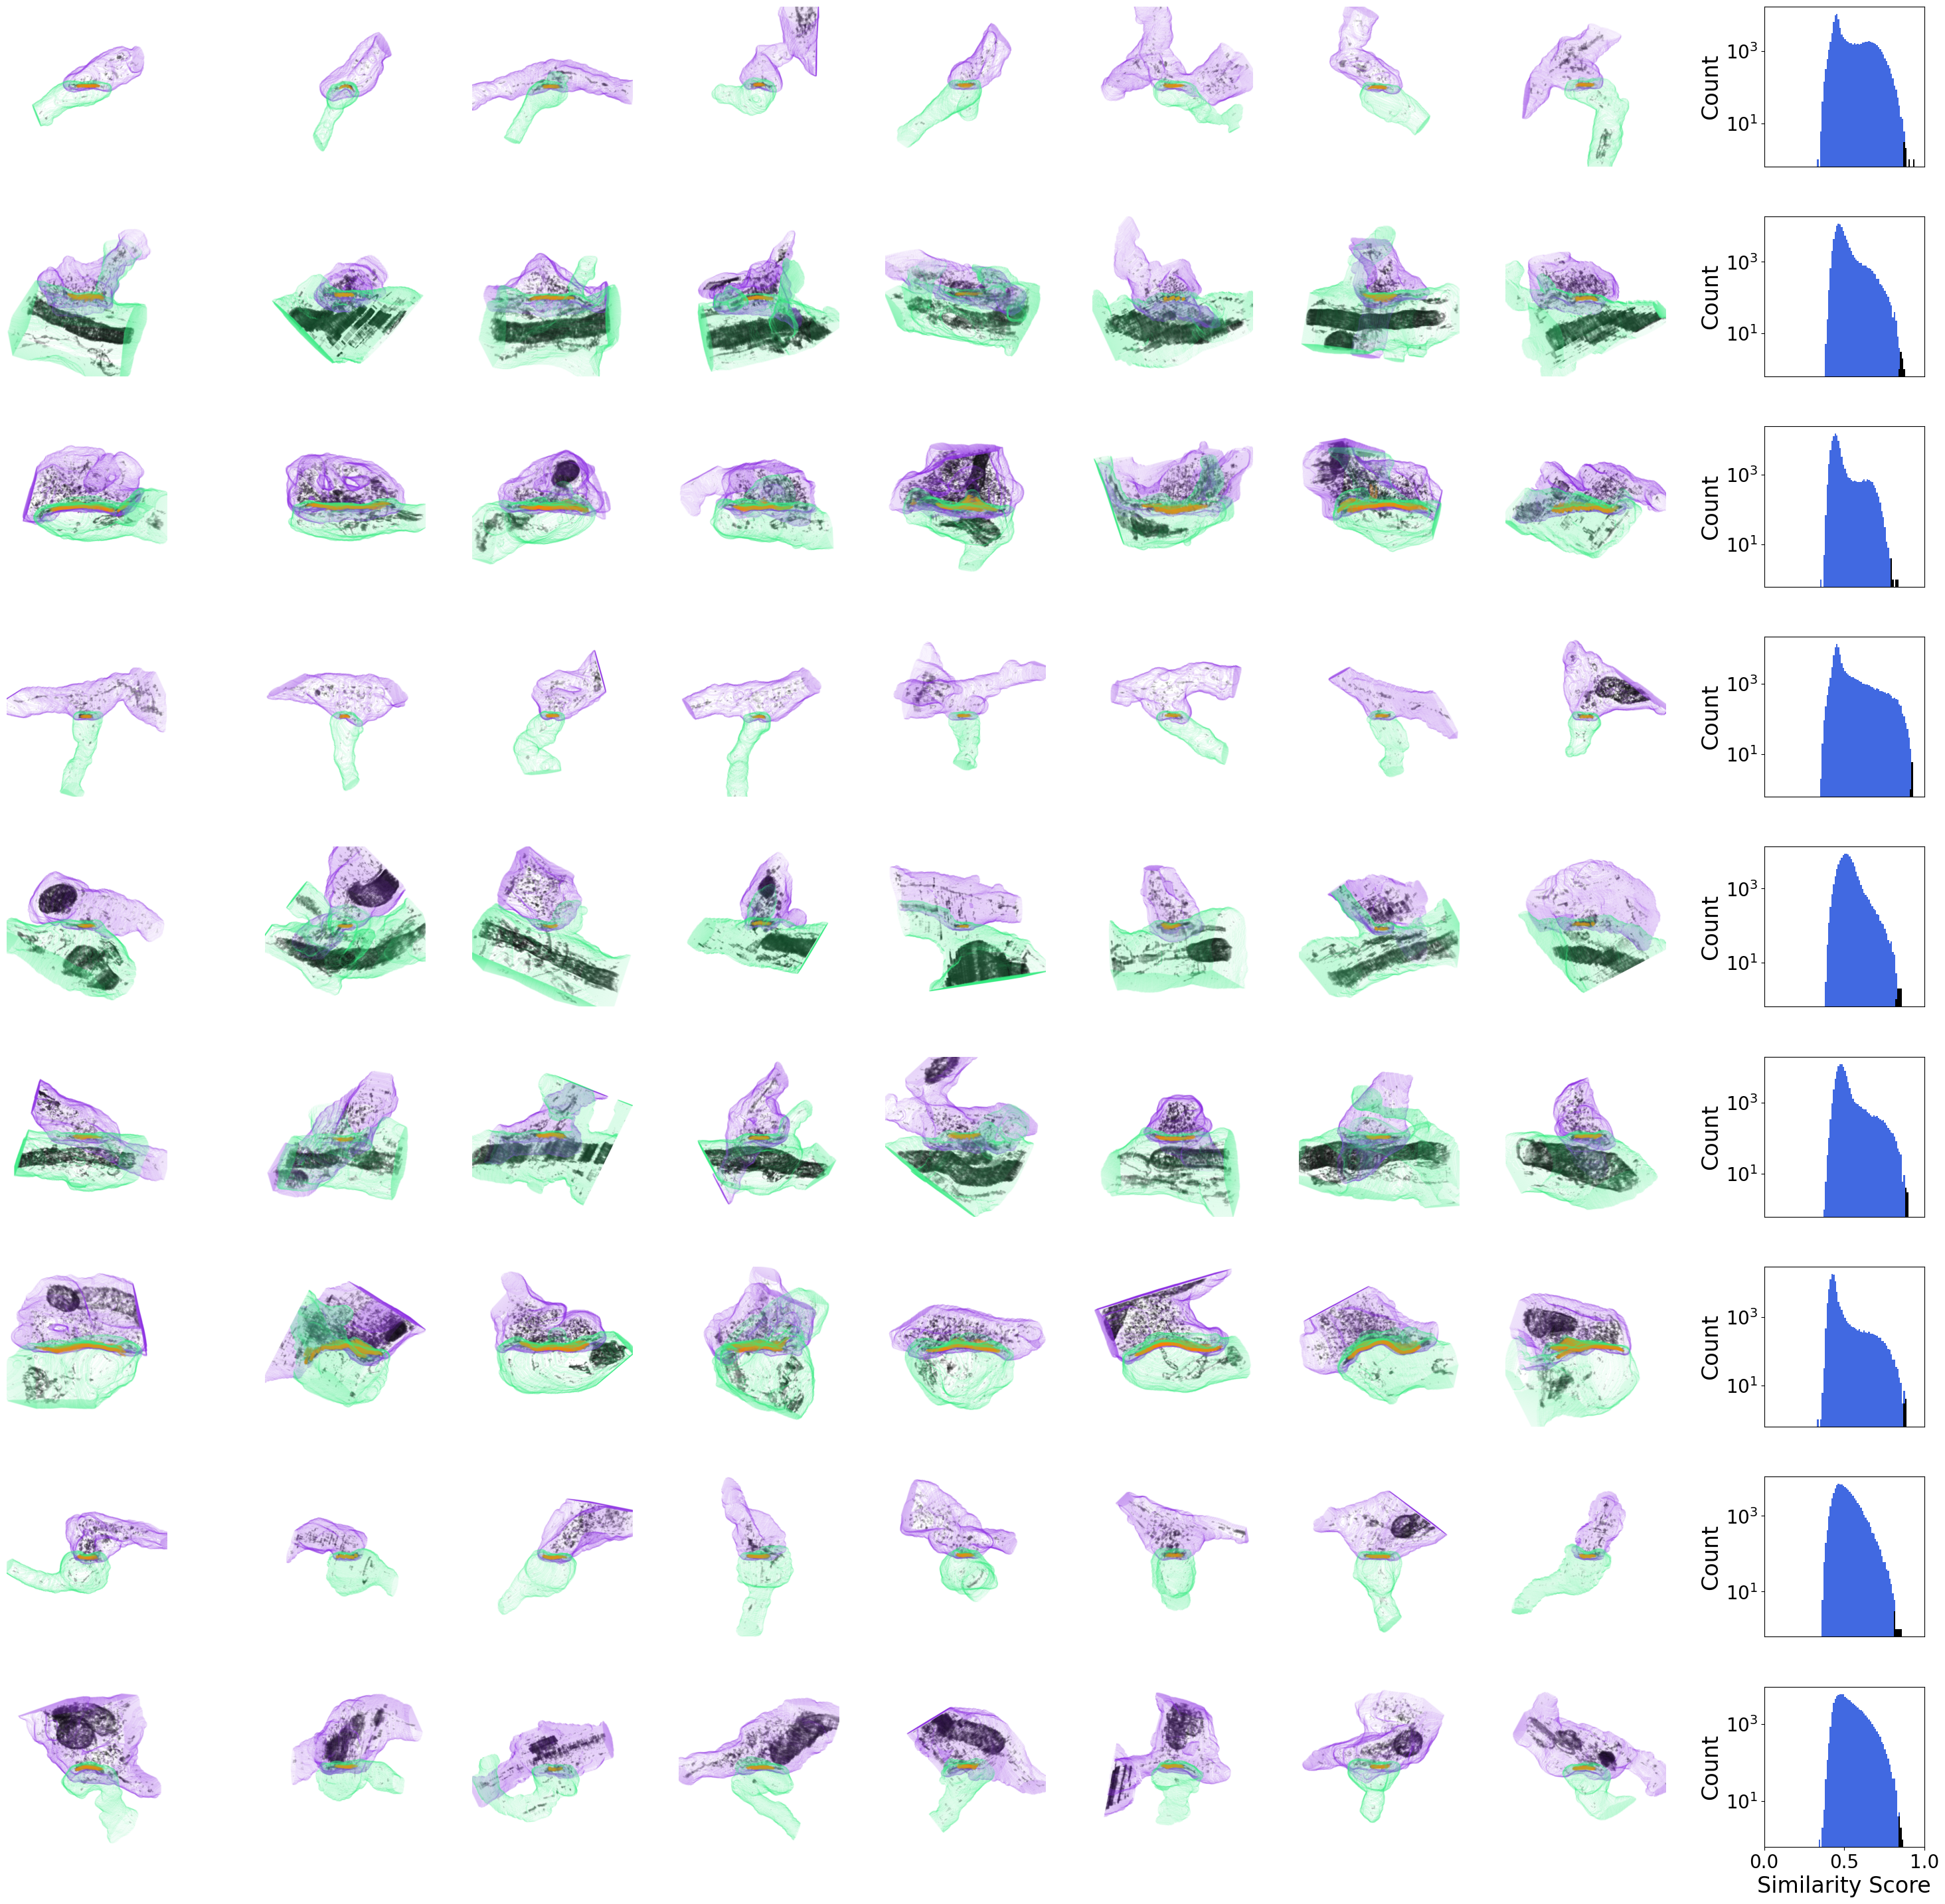

In [17]:
s = 4
scale = 1.
margin_cut = 0

ncols = s * (top_k + 2) + 2
nrows = s * len(synapse_ids)

pad = 0
fig = plt.figure(figsize=(scale * ncols, scale * nrows + pad))
gs = GridSpec(nrows, ncols, figure=fig)

for i in range(len(synapse_ids)):
    
    # build axes
    a = s * i
    ax_source = fig.add_subplot(gs[a:(a + s), 0:s])
    ax_top_k_list = [
        fig.add_subplot(gs[a:(a + s), (s + 1 + j * s):(s + 1 + j * s + s)])
        for j in range(top_k)]
    ax_dist = fig.add_subplot(gs[a:(a + s), (ncols - s):])
    
    ax_source.axis('off')
    for ax in ax_top_k_list:
        ax.axis('off')

    synapse_id = synapse_ids[i]
    synapse_index = {
        _synapse_id: _idx for _idx, _synapse_id in enumerate(meta_df['synapse_id'].values)}[synapse_id]
    dist_n = np.linalg.norm(features_nf - features_nf[synapse_index][None], axis=1)
    score_n = np.exp(-0.1 * dist_n)
    sorted_score_n = sorted(score_n, reverse=True)[1:]
    scored_k = sorted_score_n[:top_k]
    target_synapse_indices_k = np.argsort(dist_n)[:(top_k + 1)][1:]
    
    # the distribution
    ax_dist.hist(sorted_score_n, bins=bins, log=True, range=(0, 1), color='royalblue')
    ax_dist.hist(sorted_score_n[:top_k], bins=bins, log=True, range=(0, 1), color='black')
    ax_dist.set_xlim((0, 1))
    ax_dist.set_ylabel('Count')
    ax_dist.set_xlabel('Similarity Score')
    ax_dist.set_box_aspect(1.)
    ax_dist.set_xticks([0., 0.5, 1.0])
    if i != (len(synapse_ids) - 1):
        ax_dist.set_xticks([])
        ax_dist.set_xlabel(None)

    # source
    source_image = img.imread(os.path.join(
        elements_output_path, f'query__{synapse_id}__0__{synapse_id}.png'))
    ax_source.imshow(source_image[
        margin_cut:source_image.shape[0] - margin_cut,
        margin_cut:source_image.shape[1] - margin_cut])

    # top-k
    for k, ax in enumerate(ax_top_k_list):
        target_synapse_index = target_synapse_indices_k[k]
        target_synapse_id = meta_df.iloc[target_synapse_index].synapse_id
        target_image = img.imread(os.path.join(
            elements_output_path, f'query__{synapse_id}__{k + 1}__{target_synapse_id}.png'))
        ax.imshow(target_image[
            margin_cut:target_image.shape[0] - margin_cut,
            margin_cut:target_image.shape[1] - margin_cut])

        # ax.set_title(f'$d$ = {sorted_dist_n[k]:.3f}')
    
plt.subplots_adjust(wspace=None, hspace=20.)

fig.savefig(os.path.join(tile_output_path, f'synapse_simclr_knn_demo_{suffix}.pdf'), dpi=150, bbox_inches='tight')